In [ ]:
# replace weight by a custom graph input
# create library functions

In [4]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

## Taking Causal Graph as Input

In [1]:
def create_graph_from_user():
    # Initialize an empty directed graph
    graph = nx.DiGraph()
    
    # Instructions for the user
    print("Enter the graph as a list of edges with time lags. Enter 'done' when you are finished.")
    print("Each edge should be entered in the format 'node1 node2 time_lag'. For example: 'A B 4'")
    
    # Loop to receive user input
    while True:
        edge = input("Enter an edge: ")
        if edge.lower() == "done":
            break
        edge = edge.split()
        if len(edge) != 3:
            print("Invalid edge. Please enter an edge in the format 'node1 node2 time_lag'.")
            continue
        node1, node2, time_lag = edge
        try:
            time_lag = float(time_lag)
        except ValueError:
            print("Invalid weight. Please enter a numerical value for the time_lag.")
            continue
        graph.add_edge(node1, node2, time_lag=time_lag)
    
    return graph

In [2]:
def create_graph_from_csv(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Initialize an empty directed graph
    graph = nx.DiGraph()
    
    # Add edges with weights to the graph
    for index, row in df.iterrows():
        graph.add_edge(row['node1'], row['node2'], time_lag=row['time_lag'])
    
    return graph

- The user can either create a csv file with the edges in the graph or input the edges manually

In [13]:
def pretty_print_graph(graph):
    # Display the entered graph
    print("\nGraph edges with time lags:")
    for edge in graph.edges(data=True):
        print(f"{edge[0]} -> {edge[1]} with time-lagged dependency {edge[2]['time_lag']}")

In [14]:
def display_networkx_graph(graph):
    # Draw and display the graph
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True)
    labels = nx.get_edge_attributes(graph, 'time_lag')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    plt.show()


Graph edges with time lags:
1 -> 2 with time-lagged dependency 4
2 -> 3 with time-lagged dependency 5
4 -> 5 with time-lagged dependency 1
5 -> 6 with time-lagged dependency 3


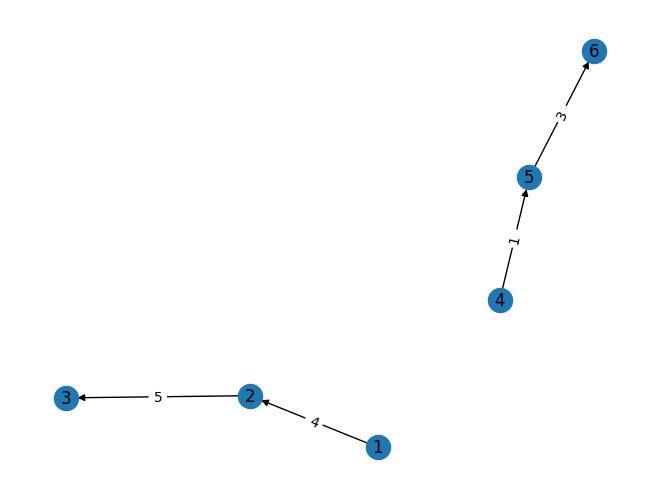

In [15]:
# Prompt user to input the path to the CSV file
file_path = "./temporal_graph.csv"

# Create the graph from the CSV file
graph = create_graph_from_csv(file_path)
pretty_print_graph(graph)
display_networkx_graph(graph)

## Dataset Shifting and Preprocessing

In [21]:
# create a function that returns a dictionary of node:weight for all the parent nodes of a given node in the networkx
# graph
def find_lagged_parent_nodes(graph, node):
    parent_nodes = {}
    for n in graph.predecessors(node):
        edge_data = graph.get_edge_data(n, node)
        if 'time_lag' in edge_data:
            parent_nodes[str(n)] = edge_data['time_lag']
    return parent_nodes

In [22]:
# read the dataframe in a csv format from the user, and then ask the user to select any 2 rows for 
# the effect estimation usecase
dataset_path="dummy_dataset.csv"
dataframe=pd.read_csv(dataset_path)

# ask the node for which effect estimation has to be done
child_node = int(input("enter the node which requires effect estimation to be done"))

# find the parent nodes of the given node with respective lag times
parents = find_lagged_parent_nodes(graph, child_node)
parents

{'4': 1}

In [23]:
# once we have the parent dictionary then we can parse it and shift columns within the dataframe with the appropriate lag
def shift_columns(df, parents):
    new_df = df.copy()
    for column, shift in parents.items():
        column=str(column)
        if shift > 0:
            new_df[column] = new_df[column].shift(shift, axis=0, fill_value=None)
        # elif shift < 0:
        #     new_df[column] = new_df[column].shift(shift, axis=0, fill_value=None)
        #     new_df.drop(new_df.index[0:abs(shift)], axis=0, inplace=True)
    return new_df

In [24]:
time_shifted_df = shift_columns(dataframe,parents)

In [25]:
time_shifted_df.head()

,1,2,3,4,5,6
0,0.1,0.2,0.3,NaN,0.5,0.6
1,0.1,0.2,0.3,1.0,0.5,0.6
2,0.1,0.2,0.3,2.0,0.5,0.6
3,0.1,0.2,0.3,3.0,0.5,0.6
4,0.1,0.2,0.3,4.0,0.5,0.6


In [26]:
def filter_columns(df, child_node, parent_nodes):
    columns_to_keep = [str(child_node)] + list(parent_nodes.keys())
    filtered_df = df[columns_to_keep]
    return filtered_df

In [27]:
filtered_ts_df = filter_columns(time_shifted_df,child_node,parents)

In [28]:
df=filtered_ts_df.fillna(0)
df.head()

,5,4
0,0.5,0.0
1,0.5,1.0
2,0.5,2.0
3,0.5,3.0
4,0.5,4.0


## Cause Estimation using Dowhy

In [29]:
# perform causal effect estimation on this new dataset
import dowhy
from dowhy import CausalModel

# Assuming 'df' is your DataFrame, 'treatment' is your treatment variable, and 'outcome' is your outcome variable
# Also assuming 'common_causes' is a list of common cause variables

model = CausalModel(
    data=df,
    treatment='4',
    outcome='5',
    # common_causes='4',
    proceed_when_unidentifiable=True  # Proceed even if the causal graph is not fully identifiable
)

identified_estimand = model.identify_effect()

estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 test_significance=True)

print(estimate)

c:\Users\t-ashutoshs\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[5])
d[4]      
Estimand assumption 1, Unconfoundedness: If U→{4} and U→5 then P(5|4,,U) = P(5|4,)

## Realized estimand
b: 5~4
Target units: ate

## Estimate
Mean value: 0.0



c:\Users\t-ashutoshs\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\t-ashutoshs\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
